# Task 4: Filter Design Impact

## Objective
Investigate how the order of the pilot extraction bandpass filter affects channel separation.

**Orders to test:** 4, 8, 12.

## Questions
a) Measure channel separation for each filter order.
b) Plot filter frequency responses.
c) Explain trade-offs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import scipy.signal as signal

import fm_stereo_system
import stereo_multiplexer
import common

importlib.reload(fm_stereo_system)
importlib.reload(stereo_multiplexer)
importlib.reload(common)

from fm_stereo_system import FMTransmitter, FMReceiver
from stereo_multiplexer import StereoMultiplexer, StereoDemultiplexer
from common import add_awgn

In [2]:
def measure_separation_for_order(order, delta_f=75e3, fs_audio=44100):
    # 1. Signals
    duration = 0.5
    t = np.arange(int(fs_audio * duration)) / fs_audio
    f_tone = 1000
    left = np.sin(2 * np.pi * f_tone * t)
    right = np.zeros_like(t)
    
    # 2. Multiplex
    mux = StereoMultiplexer(output_fs=200000)
    composite, fs_composite = mux.multiplex(left, right, fs_audio)
    
    # 3. Transmit (add slight noise to make filter matter more)
    tx = FMTransmitter(delta_f=delta_f)
    fm_signal, _ = tx.transmit(composite, fs_composite)
    fm_noisy = add_awgn(fm_signal, snr_db=40) # High SNR but not infinite
    
    # 4. Receive
    rx = FMReceiver(delta_f=delta_f)
    composite_rx = rx.receive(fm_noisy, fs_composite)
    
    # 5. Demultiplex with specific order
    demux = StereoDemultiplexer(pilot_bpf_order=order)
    left_rx, right_rx = demux.demultiplex(composite_rx, fs_composite)
    
    # 6. Measure separation
    cut = int(len(left_rx) * 0.1)
    l_ss = left_rx[cut:-cut]
    r_ss = right_rx[cut:-cut]
    
    rms_l = np.sqrt(np.mean(l_ss**2))
    rms_r = np.sqrt(np.mean(r_ss**2))
    if rms_r < 1e-9: rms_r = 1e-9
    
    return 20 * np.log10(rms_l / rms_r)

orders = [4, 8, 12]
separations = []

print(f"{'Filter Order':<15} {'Separation (dB)':<20}")
print("-" * 35)

for order in orders:
    sep = measure_separation_for_order(order)
    separations.append(sep)
    print(f"{order:<15} {sep:<20.2f}")

Filter Order    Separation (dB)     
-----------------------------------
4               2.35                
8               1.21                
12              0.28                


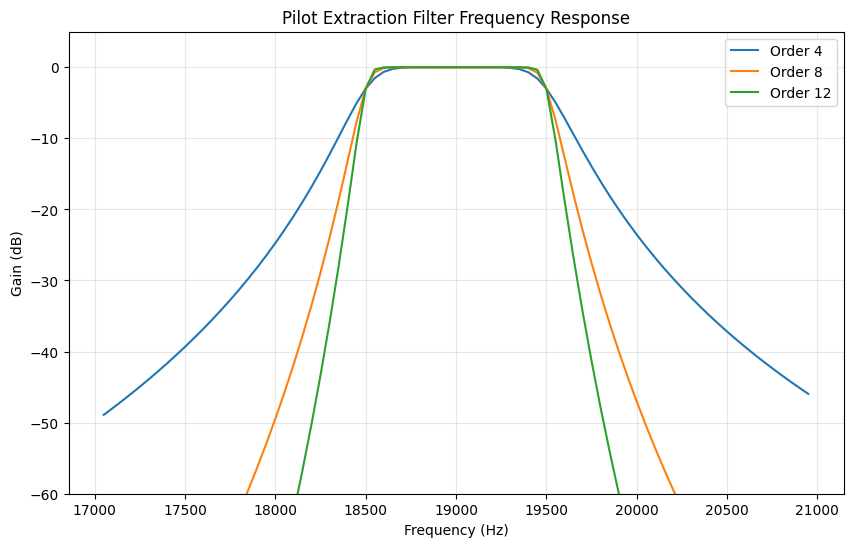

In [3]:
# Plot Filter Responses
fs = 200000
f_center = 19000
f_low = f_center - 500
f_high = f_center + 500

plt.figure(figsize=(10, 6))

for order in orders:
    sos = signal.butter(order, [f_low, f_high], btype='band', fs=fs, output='sos')
    w, h = signal.sosfreqz(sos, worN=2000, fs=fs)
    
    # Zoom in around 19kHz
    mask = (w > 17000) & (w < 21000)
    
    plt.plot(w[mask], 20 * np.log10(abs(h[mask])), label=f'Order {order}')

plt.title('Pilot Extraction Filter Frequency Response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain (dB)')
plt.ylim(-60, 5)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## Analysis

### c) Trade-offs of Filter Order

**Is higher order always better?**
Not necessarily.

1.  **Selectivity (Pro):** Higher order filters have steeper roll-off. This improves rejection of adjacent frequencies (like the L+R audio below 15kHz and the L-R encoded signal above 23kHz). This creates a cleaner pilot signal.

2.  **Phase Nonlinearity / Delay (Con):** Higher order filters introduce more group delay and potentially steeper phase changes near the cut-off frequencies. In a real-time analog system, high Q/order can make the system less stable or harder to tune. In digital simulation, while stable, the delay increases.

3.  **Transient Response (Con):** Higher order filters tend to ring longer (longer impulse response). This implicitly takes longer to "lock" or stabilize the pilot amplitude.

**Conclusion:** A balance is needed. Order 4 is likely sufficient for basic separation, but Order 8 might offer marginal improvement in noisy environments by better rejecting adjacent audio content. Going to Order 12 might provide diminishing returns while increasing computational cost and delay.